In [2]:
from cognitive_models import *
import unittest
import numpy as np
from numpy.typing import NDArray
import copy
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, Dict, Tuple, List, Union, Callable
from typing import List
from numpy.typing import NDArray
from ast import literal_eval


# CONTEXTS = {
#     'A_B': {'A': {1: 0.8, -1: 0.2}, 'B': {1: 0.2, -1: 0.8}},
#     'C_D': {'C': {1: 0.7, -1: 0.3}, 'D': {1: 0.3, -1: 0.7}},
#     'E_F': {'E': {1: 0.6, -1: 0.4}, 'F': {1: 0.4, -1: 0.6}},
# }
# TRANSITIONS = {
#     'A_B': {'A': {'A_B':1/3,'C_D':1/3,'E_F':1/3},'B': {'A_B':1/3,'C_D':1/3,'E_F':1/3}},
#     'C_D': {'C': {'A_B':1/3,'C_D':1/3,'E_F':1/3},'D': {'A_B':1/3,'C_D':1/3,'E_F':1/3}},
#     'E_F': {'E': {'A_B':1/3,'C_D':1/3,'E_F':1/3},'F': {'A_B':1/3,'C_D':1/3,'E_F':1/3}},
# }


CONTEXTS,TRANSITIONS = parse_mdp_config("cognitive_models/tasks/mdp_pl_config.json")

class StateTask(State):
    def __init__(self, name: str=None):
        super().__init__(name)
class StateQ(State):
    def __init__(self, name: str=None, Q: NDArray[np.float64]=None):
        super().__init__(name)
        self.Q = Q







StatesTask = np.empty((3,),dtype=object)
for i,k in enumerate(list(CONTEXTS.keys())):
    StatesTask[i] = StateTask(k)           
task_mdp = PL(StatesTask,CONTEXTS,TRANSITIONS)



StatesAgent = np.empty((3,),dtype=object)
for i,k in enumerate(list(CONTEXTS.keys())):
    StatesAgent[i] = StateQ(k,np.zeros((2,)))


    
        




## Create a simulated data
### Define the range parameters using uniform strategy
NumberSubjects = 10

#### Define ranges for each parameter
alphaPrange = (0.1, 1)
alphaNrange = (0.1, 1)

#### Generate uniformly distributed samples
alphaPsamples = np.random.uniform(*alphaPrange, NumberSubjects)
alphaNsamples = np.random.uniform(*alphaNrange, NumberSubjects)

#### Generate Guassian Range

alphaNsamplesG = AbstractQL.logistic_transform(alphaNsamples)
alphaPsamplesG = AbstractQL.logistic_transform(alphaPsamples)



### Define the range parameters using guassian(I am going to implement it) 





#### Combine into a single array
samples = np.column_stack((alphaPsamples , alphaNsamples ))



# ### Generate the simulate actions 
# Trials = 200
# Agents = np.empty(shape=(NumberSubjects,1),dtype=object)
# Trajectories = np.zeros((NumberSubjects,Trials,3)).astype(int)
# for i in np.arange(NumberSubjects).astype(int):
#     # you need to take copy to sure that in each simulation the initial Q value are the same for all simulated subjects
#     Agents[i,0] = QL1_RL(task_mdp,copy.deepcopy(StatesAgent),samples[i,0],samples[i,1])
#     environment = MDPEnvironment(Agents[i,0], task_mdp)
#     Agents[i],Trajectories[i] = environment.simulate_interaction(initial_state_idx=0,max_steps=Trials)

# DummyAgent = QL1_RL(task_mdp,copy.deepcopy(StatesAgent),0.1,0.1)
# EnvFit = MDPEnvironment(DummyAgent, task_mdp)
# EMFit = EMGuassian(EnvFit,2,20)

# behavioraldata  = Trajectories
# print(EMFit.prior_mean)

## Load Real Behavioral Data

In [6]:
import pandas as pd
import ast

PathTofile = "/media/mohammad/New Volume/DoctoralSharif/Articles/RL and MDD/git/RL-and-DD/Data/BehvioralData/Subjects_Performance.csv"
# Load CSV file
df = pd.read_csv(PathTofile)

# Display first few rows

In [3]:
def custom_task_loader(file_path: str,
                      task_col: str = 'Task', subject_group:str = 'D', **kwargs) -> List[NDArray]:
    """
    Custom data loader for CSV files with a Task column containing string lists of
    [stimulus, reaction_time, choice, reward] arrays.
    
    Parameters:
    - file_path (str): Path to the CSV file.
    - subject_col (str): Column name for subject IDs (used for grouping).
    - task_col (str): Column name for Task data (string lists of T*4 arrays).
    - **kwargs: Additional arguments for pandas.read_csv.
    
    Returns:
    - List[NDArray]: List of per-subject data arrays (shape (n_trials, 3)).
      Each NDArray contains [stimulus, choice, reward] columns. The order of arrays
      matches the order of subjects in the file.
    """
    df = pd.read_csv(file_path, **kwargs)
    df = df.drop(37)

    if subject_group == 'CTL':
       df = df[df["BDI"]<=7] 
    elif subject_group == "D":
       df = df[df["BDI"]>=13] 



       
    
    required_cols = [task_col]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    df = df.dropna(subset=required_cols)
    if df.empty:
        raise ValueError("No valid data after removing missing values")
    
    behavioral_data: List[NDArray] = []
    
    for _, row in df.iterrows():
        try:
            task_data = np.array(literal_eval(row[task_col]), dtype=float)
        except Exception as e:
            raise ValueError(f"Failed to parse Task data for subject {row[task_col]}: {e}")
        
        if task_data.ndim != 2 or task_data.shape[1] != 4:
            raise ValueError(f"Task data for subject {row[task_col]} must be T*4, got shape {task_data.shape}")
        
        # Extract [stimulus, choice, reward] (indices 0, 2, 3)
        data = task_data[:, [0, 2, 3]].astype(int)
        behavioral_data.append(data)
    
    if not behavioral_data:
        raise ValueError("No valid subject data found")
    
    return behavioral_data

In [4]:
len(custom_task_loader(PathTofile,'Task','D'))

46

## Fit to Real Data

In [ ]:
# Setup environment
config_path = "cognitive_models/tasks/mdp_pl_config.json"  # Adjust path as needed
try:
    CONTEXTS, TRANSITIONS = parse_mdp_config(config_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Configuration file not found: {config_path}")

# Create task and agent states
StatesTask = np.array([State(name=k) for k in CONTEXTS.keys()])
task_mdp = PL(StatesTask, CONTEXTS, TRANSITIONS)
StatesAgent = np.array([StateQ(k, np.zeros((2,))) for k in CONTEXTS.keys()])

# Initialize agent and environment
agent = QL1_RL(task_mdp, StatesAgent, alphaP=0.1, alphaN=0.1)
env = MDPEnvironment(agent, task_mdp)

# Initialize EMGuassian with custom data loader
em = EMGuassian(
    environment=env,
    num_params=2,  # Assuming 2 parameters (e.g., alpha, gamma)
    num_iteration_em=20,  # Small number for testing
    num_iteration_gradient_descent=10000,  # Reduced for faster testing
    learning_rate=0.01,
    tol=1e-6,
    data_loader=custom_task_loader)

try:
    EstimatedData = em.fit(
            behavioral_data=PathTofile,
            task_col="Task"
        )
except Exception as e:
        print(f"Model fitting failed: {e}")

In [7]:
EstimatedData

{'prior_mean': array([-0.45016152, -1.5621221 ]),
 'prior_variance': array([4.71567453, 4.37324683]),
 'subject_means': array([[ 2.64170587e-01, -5.34872413e-01],
        [ 1.34075546e+00, -4.46694374e+00],
        [-8.13941360e-01, -2.12987185e+00],
        [ 1.55209768e+00, -1.30996525e+00],
        [-5.07264900e+00,  6.54115498e-01],
        [ 6.92815125e-01,  2.28853416e+00],
        [-7.76692510e-01, -3.14238286e+00],
        [ 1.16708624e+00,  1.42811332e-05],
        [-1.30288208e+00, -1.93832946e+00],
        [ 1.41191185e+00, -1.08433628e+00],
        [-2.53680110e+00, -6.54221892e-01],
        [-2.07236648e+00, -3.54258966e+00],
        [-1.83854416e-01, -3.11847019e+00],
        [ 9.35337096e-02, -1.64721310e+00],
        [ 1.45526421e+00, -2.27396822e+00],
        [-1.16596234e+00, -1.32664514e+00],
        [ 3.97729009e-01, -2.95214593e-01],
        [ 3.74740474e-02, -1.76423490e+00],
        [-6.01886630e-01, -4.22590590e+00],
        [-1.03536807e-01, -2.07550168e+00],
 

## Fit to Available Subjects 

#### Load Availabel Data

In [3]:
A = np.load("/media/mohammad/New Volume/DoctoralSharif/Articles/RL and MDD/FittedData/AvailableSubjects.npy")

In [4]:
def custom_task_loader(file_path: str,available: NDArray = A[1,:], 
                      task_col: str = 'Task', subject_group:str = 'D',**kwargs) -> List[NDArray]:
    """
    Custom data loader for CSV files with a Task column containing string lists of
    [stimulus, reaction_time, choice, reward] arrays.
    
    Parameters:
    - file_path (str): Path to the CSV file.
    - subject_col (str): Column name for subject IDs (used for grouping).
    - task_col (str): Column name for Task data (string lists of T*4 arrays).
    - **kwargs: Additional arguments for pandas.read_csv.
    
    Returns:
    - List[NDArray]: List of per-subject data arrays (shape (n_trials, 3)).
      Each NDArray contains [stimulus, choice, reward] columns. The order of arrays
      matches the order of subjects in the file.
    """
    df = pd.read_csv(file_path, **kwargs)
    df = df.drop(37)

    if subject_group == 'CTL':
       df = df[df["BDI"]<=7] 
    elif subject_group == "D":
       df = df[df["BDI"]>=13] 

    df = df[df["ID"].isin(available)]
       
    
    required_cols = [task_col]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    df = df.dropna(subset=required_cols)
    if df.empty:
        raise ValueError("No valid data after removing missing values")
    
    behavioral_data: List[NDArray] = []
    
    for _, row in df.iterrows():
        try:
            task_data = np.array(literal_eval(row[task_col]), dtype=float)
        except Exception as e:
            raise ValueError(f"Failed to parse Task data for subject {row[task_col]}: {e}")
        
        if task_data.ndim != 2 or task_data.shape[1] != 4:
            raise ValueError(f"Task data for subject {row[task_col]} must be T*4, got shape {task_data.shape}")
        
        # Extract [stimulus, choice, reward] (indices 0, 2, 3)
        data = task_data[:, [0, 2, 3]].astype(int)
        behavioral_data.append(data)
    
    if not behavioral_data:
        raise ValueError("No valid subject data found")
    
    return behavioral_data

In [7]:
len(custom_task_loader(PathTofile))

44

In [8]:
# Setup environment
config_path = "cognitive_models/tasks/mdp_pl_config.json"  # Adjust path as needed
try:
    CONTEXTS, TRANSITIONS = parse_mdp_config(config_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Configuration file not found: {config_path}")

# Create task and agent states
StatesTask = np.array([State(name=k) for k in CONTEXTS.keys()])
task_mdp = PL(StatesTask, CONTEXTS, TRANSITIONS)
StatesAgent = np.array([StateQ(k, np.zeros((2,))) for k in CONTEXTS.keys()])

# Initialize agent and environment
agent = QL1_RL(task_mdp, StatesAgent, alphaP=0.1, alphaN=0.1)
env = MDPEnvironment(agent, task_mdp)

# Initialize EMGuassian with custom data loader
em = EMGuassian(
    environment=env,
    num_params=2,  # Assuming 2 parameters (e.g., alpha, gamma)
    num_iteration_em=20,  # Small number for testing
    num_iteration_gradient_descent=10000,  # Reduced for faster testing
    learning_rate=0.01,
    tol=1e-6,
    data_loader=custom_task_loader)

try:
    EstimatedData = em.fit(
            behavioral_data=PathTofile,
            task_col="Task"
        )
except Exception as e:
        print(f"Model fitting failed: {e}")

EM Iterations: 100%|██████████| 20/20 [1:27:52<00:00, 263.63s/iter]

Iteration 20 completed, mean change: 0.474718, prior mean: [-1.05177815 -1.60445206]


In [9]:
EstimatedData["subject_means"].shape

(44, 2)

In [10]:
import pickle

with open("/media/mohammad/New Volume/DoctoralSharif/Articles/RL and MDD/FittedData/available_dp_data.pkl", "wb") as file:
    pickle.dump(EstimatedData, file)

In [11]:
# Load the .pkl file
with open("/media/mohammad/New Volume/DoctoralSharif/Articles/RL and MDD/FittedData/data.pkl", "rb") as file:
    loaded_dict = pickle.load(file)

In [12]:
loaded_dict

{'prior_mean': array([-0.45016152, -1.5621221 ]),
 'prior_variance': array([4.71567453, 4.37324683]),
 'subject_means': array([[ 2.64170587e-01, -5.34872413e-01],
        [ 1.34075546e+00, -4.46694374e+00],
        [-8.13941360e-01, -2.12987185e+00],
        [ 1.55209768e+00, -1.30996525e+00],
        [-5.07264900e+00,  6.54115498e-01],
        [ 6.92815125e-01,  2.28853416e+00],
        [-7.76692510e-01, -3.14238286e+00],
        [ 1.16708624e+00,  1.42811332e-05],
        [-1.30288208e+00, -1.93832946e+00],
        [ 1.41191185e+00, -1.08433628e+00],
        [-2.53680110e+00, -6.54221892e-01],
        [-2.07236648e+00, -3.54258966e+00],
        [-1.83854416e-01, -3.11847019e+00],
        [ 9.35337096e-02, -1.64721310e+00],
        [ 1.45526421e+00, -2.27396822e+00],
        [-1.16596234e+00, -1.32664514e+00],
        [ 3.97729009e-01, -2.95214593e-01],
        [ 3.74740474e-02, -1.76423490e+00],
        [-6.01886630e-01, -4.22590590e+00],
        [-1.03536807e-01, -2.07550168e+00],
 

In [8]:
index = 37
a = df['Task'][index]
b = df['Num_Trials'][index]
data_list = ast.literal_eval(a)
numpy_array = np.array(data_list)
numpy_array.shape

(174, 4)

In [44]:
np.isnan(b1)

True

In [46]:
invalidIndexes = []
NanIndexNumTrial = []
for index in range(df.shape[0]):
    a = df['Task'][index]
    b = df['Num_Trials'][index]
    data_list = ast.literal_eval(a)
    numpy_array = np.array(data_list)
    c = numpy_array.shape[0]
    # print("!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    # print(index)
    # print("!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(c)
    print(b)
    if np.isnan(b):
        NanIndexNumTrial.append(index)
        continue
    if int(b) != c:
       invalidIndexes.append(index)

        

120
120.0
360
360.0
60
60.0
180
180.0
360
360.0
120
120.0
299
300.0
180
180.0
120
120.0
360
360.0
240
240.0
120
120.0
240
240.0
240
240.0
60
60.0
359
359.0
360
360.0
60
60.0
360
360.0
240
240.0
120
120.0
240
240.0
180
180.0
300
300.0
360
360.0
361
360.0
240
240.0
360
360.0
48
60.0
180
180.0
360
360.0
120
120.0
359
360.0
352
360.0
120
120.0
60
60.0
120
120.0
174
nan
180
180.0
56
60.0
240
240.0
173
180.0
357
360.0
240
240.0
61
60.0
240
240.0
176
180.0
359
360.0
294
300.0
60
60.0
300
300.0
355
360.0
120
120.0
56
60.0
297
300.0
60
60.0
115
120.0
176
180.0
120
120.0
240
240.0
60
60.0
360
360.0
360
360.0
240
240.0
120
120.0
240
240.0
60
60.0
180
180.0
60
60.0
360
360.0
360
360.0
361
360.0
121
120.0
355
360.0
180
180.0
360
360.0
120
120.0
60
60.0
360
360.0
355
360.0
359
360.0
120
120.0
116
120.0
356
360.0
360
360.0
354
360.0
236
240.0
121
120.0
360
360.0
178
180.0
357
360.0
60
60.0
360
360.0
180
180.0
360
360.0
361
360.0
241
240.0
296
300.0
119
120.0
180
180.0
360
360.0
240
240.0
361
360.0
35

In [49]:
len(invalidIndexes)
len(NanIndexNumTrial)

1

In [2]:
behavioraldata.shape

(10, 200, 3)

In [5]:
import pickle

pickle.dumps(EMFit)  # Try pickling the EMGuassian instance
pickle.dumps(EMFit.environment)  # Try pickling the environment

b"\x80\x04\x95q\x06\x00\x00\x00\x00\x00\x00\x8c%cognitive_models.learning.environment\x94\x8c\x0eMDPEnvironment\x94\x93\x94)\x81\x94}\x94(\x8c\x05agent\x94\x8c#cognitive_models.learning.QLearning\x94\x8c\x06QL1_RL\x94\x93\x94)\x81\x94}\x94(\x8c\x06states\x94\x8c\x15numpy.core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94\x87\x94R\x94(K\x01K\x03\x85\x94h\x0f\x8c\x05dtype\x94\x93\x94\x8c\x02O8\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01|\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK?t\x94b\x89]\x94(\x8c\x08__main__\x94\x8c\x06StateQ\x94\x93\x94)\x81\x94}\x94(\x8c\x04name\x94\x8c\x03A_B\x94\x8c\x08sub_task\x94N\x8c\x01Q\x94h\x0eh\x11K\x00\x85\x94h\x13\x87\x94R\x94(K\x01K\x02\x85\x94h\x18\x8c\x02f8\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94b\x89C\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x94t\x94bubh!)\x81\x94}\x94(h$\x8c\x03C_D\x94h&Nh'h\x0eh\x11K\x00\x85\x9

EM Iterations: 100%|██████████| 20/20 [28:44<00:00, 86.24s/iter]

Iteration 20 completed, mean change: 0.046084, prior mean: [ 0.12521144 -0.13677261]


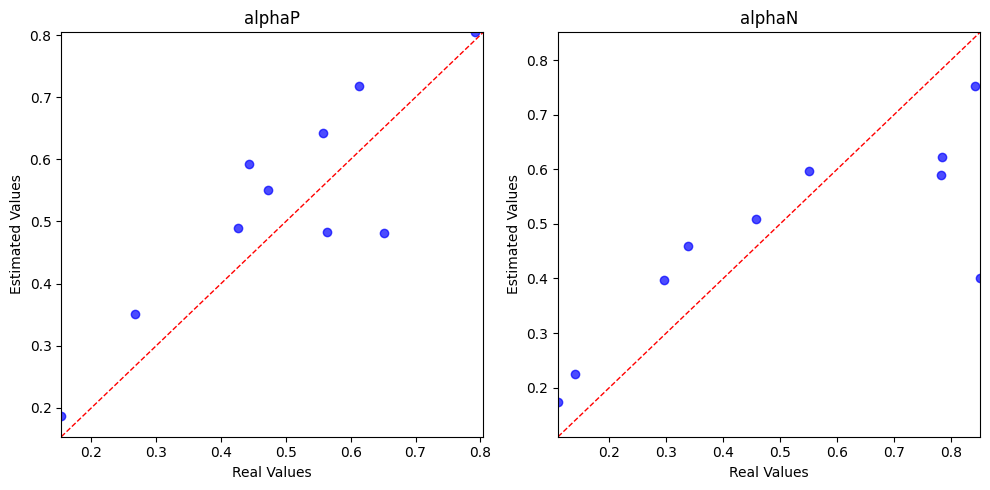

In [2]:
##### Apply Model Fitting
EstimatedData = EMFit.fit(behavioraldata)

estimated_params = EstimatedData['subject_means']

estimated_params = AbstractQL.inv_logistic_transform(estimated_params)

real_params = samples 

parameter_names=["alphaP", "alphaN"]
##### Plot the real and estimated data
num_parameters = real_params.shape[1]
fig, axes = plt.subplots(1, num_parameters, figsize=(5 * num_parameters, 5), sharey=False)

# if parameter_names is None:
#     parameter_names = [f"Parameter {i+1}" for i in range(num_parameters)]

for i in range(num_parameters):
    ax = axes[i] if num_parameters > 1 else axes  # Adjust if only one subplot

    # Scatter plot for each parameter
    ax.scatter(real_params[:, i], estimated_params[:, i], color='blue', alpha=0.7)
    
    # Plot y=x line for reference
    min_val = min(np.min(real_params[:, i]), np.min(estimated_params[:, i]))
    max_val = max(np.max(real_params[:, i]), np.max(estimated_params[:, i]))
    ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=1)

    # Label axes and add title for each subplot
    ax.set_xlabel("Real Values")
    ax.set_ylabel("Estimated Values")
    ax.set_title(parameter_names[i])
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)

plt.tight_layout()
plt.show()##### Apply Model Fitting

In [ ]:
from scipy.stats import pearsonr
i = 0
print(np.corrcoef(real_params[:, i], estimated_params[:, i])[0, 1])
i = 1
print(np.corrcoef(real_params[:, i], estimated_params[:, i])[0, 1])

0.8502830062655024
0.6746204045649549


In [3]:
from scipy.stats import pearsonr
i = 0
print(np.corrcoef(real_params[:, i], estimated_params[:, i])[0, 1])
i = 1
print(np.corrcoef(real_params[:, i], estimated_params[:, i])[0, 1])

0.8636061169799397
0.7962358628826844


In [10]:
from scipy.stats import pearsonr
i=0
cor,pval = pearsonr(real_params[:, i], estimated_params[:, i])

print(cor,pval)

i=1
cor,pval = pearsonr(real_params[:, i], estimated_params[:, i])

print(cor,pval)

0.8502830062655024 7.399671674784027e-08
0.6746204045649549 0.000216737575945393


## Plot the form of the Free Energy 

In [24]:
behavioraldata[13]

array([[ 0,  1, -1],
       [ 0,  0,  1],
       [ 0,  0,  1],
       [ 2,  1,  1],
       [ 0,  0,  1],
       [ 2,  1, -1],
       [ 0,  0,  1],
       [ 1,  0,  1],
       [ 2,  1, -1],
       [ 2,  0, -1],
       [ 2,  1, -1],
       [ 2,  0, -1],
       [ 2,  1,  1],
       [ 2,  1, -1],
       [ 0,  1,  1],
       [ 0,  0,  1],
       [ 2,  1,  1],
       [ 0,  0,  1],
       [ 2,  1,  1],
       [ 2,  1,  1],
       [ 2,  0,  1],
       [ 2,  1,  1],
       [ 2,  1,  1],
       [ 0,  1,  1],
       [ 0,  0,  1],
       [ 1,  0, -1],
       [ 1,  0, -1],
       [ 1,  1, -1],
       [ 0,  1, -1],
       [ 0,  0,  1],
       [ 1,  1, -1],
       [ 0,  0,  1],
       [ 2,  1,  1],
       [ 2,  1, -1],
       [ 0,  1, -1],
       [ 0,  0,  1],
       [ 1,  1, -1],
       [ 2,  0, -1],
       [ 2,  1, -1],
       [ 1,  0, -1],
       [ 2,  1, -1],
       [ 1,  0,  1],
       [ 2,  0,  1],
       [ 1,  0, -1],
       [ 0,  0,  1],
       [ 1,  1, -1],
       [ 1,  0,  1],
       [ 0,  

In [18]:
# Placeholder function for ln P(A_i | h_i)
def log_p_a_given_h(h_i,i):
    """
    Dummy implementation of ln P(A_i | h_i).
    Takes h_i as a 2D vector [h_1i, h_2i] and returns a scalar.
    Replace this with the actual implemented function.

    """
    return EMFit.log_likelihood(behavioraldata[i],np.expand_dims(h_i,axis=0))
    # For demonstration, assume a simple quadratic form
    # return -0.5 * np.sum(h_i**2)


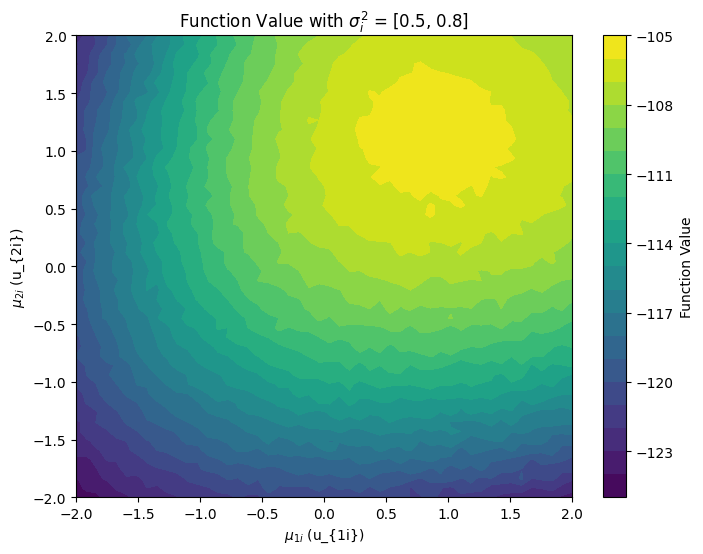

In [ ]:
mu1 = np.linspace(-10,10,100)
mu2 = np.linspace(-10,10,100)

sigma1 = np.linspace(0,10,100)
sigma2 = np.linspace(0,10,100)


import numpy as np


def compute_function(u_i, sigma2_i, mu_p, sigma2_p, i, num_samples=1000):
    """
    Compute the given function for D=2 using Monte Carlo sampling.
    
    Parameters:
    - u_i: 2D array [u_1i, u_2i], mean of the Gaussian
    - sigma2_i: 2D array [sigma^2_1i, sigma^2_2i], variances (fixed)
    - mu_p: 2D array [mu_p1, mu_p2], prior mean
    - sigma2_p: 2D array [sigma^2_p1, sigma^2_p2], prior variances
    - num_samples: Number of Monte Carlo samples (default: 1000)
    
    Returns:
    - Value of the function
    """
    # Ensure inputs are numpy arrays
    u_i = np.array(u_i)  # [u_1i, u_2i]
    sigma2_i = np.array(sigma2_i)  # [sigma^2_1i, sigma^2_2i]
    mu_p = np.array(mu_p)  # [mu_p1, mu_p2]
    sigma2_p = np.array(sigma2_p)  # [sigma^2_p1, sigma^2_p2]

    # Check dimensions
    if u_i.shape != (2,) or sigma2_i.shape != (2,) or mu_p.shape != (2,) or sigma2_p.shape != (2,):
        raise ValueError("All input arrays must be 2D vectors")

    # Step 1: Monte Carlo sampling for the integral
    # Sample h_i from N(u_i, diag(sigma2_i))
    sigma_i = np.sqrt(sigma2_i)  # Standard deviations [sigma_1i, sigma_2i]
    h_samples = np.random.normal(loc=u_i, scale=sigma_i, size=(num_samples, 2))
    
    # Compute ln P(A_i | h_i) for each sample
    log_p_values = np.array([log_p_a_given_h(h,i) for h in h_samples])
    
    # Average over samples
    integral_approx = np.mean(log_p_values)

    # Step 2: Compute the second term (KL-like term)
    kl_term = 0
    for j in range(2):
        kl_term -= (sigma2_i[j] + (u_i[j] - mu_p[j])**2) / (2 * sigma2_p[j])

    # Step 3: Compute the third term (log variance term)
    log_var_term = 0.5 * np.sum(np.log(sigma2_i))

    # Combine all terms
    result = integral_approx + kl_term + log_var_term
    
    return result

def plot_function_2d(sigma2_i, mu_p, sigma2_p, index_sub, u1_range=(-2, 2), u2_range=(-2, 2), grid_size=50, num_samples=1000):
    """
    Plot the function as a 2D heatmap over u_1i and u_2i.
    
    Parameters:
    - sigma2_i: Fixed [sigma^2_1i, sigma^2_2i]
    - mu_p: Prior mean [mu_p1, mu_p2]
    - sigma2_p: Prior variances [sigma^2_p1, sigma^2_p2]
    - u1_range: Tuple (min, max) for u_1i
    - u2_range: Tuple (min, max) for u_2i
    - grid_size: Number of points in each dimension
    - num_samples: Number of Monte Carlo samples
    """
    # Create grid of u_1i and u_2i values
    u1_vals = np.linspace(u1_range[0], u1_range[1], grid_size)
    u2_vals = np.linspace(u2_range[0], u2_range[1], grid_size)
    U1, U2 = np.meshgrid(u1_vals, u2_vals)
    
    # Compute function values over the grid
    Z = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            u_i = [U1[i, j], U2[i, j]]
            Z[i, j] = compute_function(u_i, sigma2_i, mu_p, sigma2_p,index_sub, num_samples)
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.contourf(U1, U2, Z, levels=20, cmap='viridis')
    plt.colorbar(label='Function Value')
    plt.xlabel(r'$\mu_{1i}$ (u_{1i})')
    plt.ylabel(r'$\mu_{2i}$ (u_{2i})')
    plt.title(f'Function Value with $\sigma^2_i$ = {sigma2_i}')
    plt.show()

# Example usage
if __name__ == "__main__":
    # Fixed parameters
    sigma2_i = [0.5, 0.8]         # Fixed variances [sigma^2_1i, sigma^2_2i]
    mu_p = [0.0, 0.0]             # Prior mean [mu_p1, mu_p2]
    sigma2_p = [1.0, 1.0]         # Prior variances [sigma^2_p1, sigma^2_p2]
    
    # Plot the function
    plot_function_2d(
        sigma2_i=sigma2_i,
        mu_p=mu_p,
        sigma2_p=sigma2_p,
        index_sub=0,
        u1_range=(-2, 2),
        u2_range=(-2, 2),
        grid_size=50,
        num_samples=500  # Reduced for faster plotting; increase for accuracy
    )




In [10]:
grid_size = 50

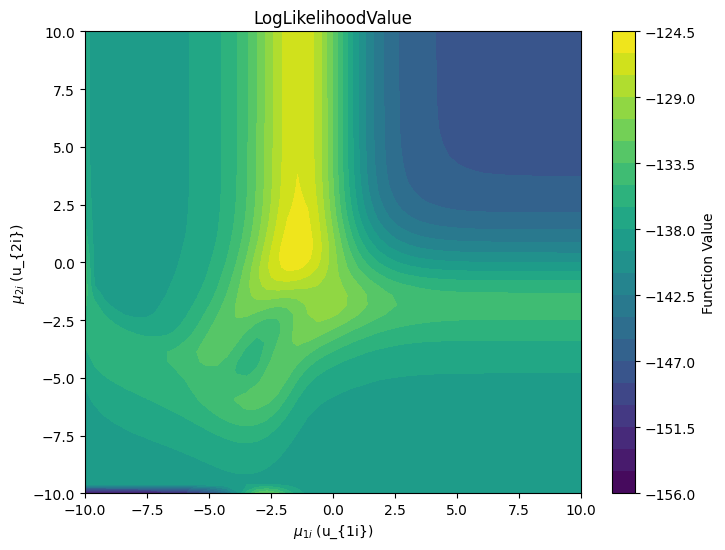

In [34]:
index_sub= 70
u1_range=[-10, 10]
u2_range=[-10, 10]
grid_size = 50
# Create grid of u_1i and u_2i values
u1_vals = np.linspace(u1_range[0], u1_range[1], grid_size)
u2_vals = np.linspace(u2_range[0], u2_range[1], grid_size)
U1, U2 = np.meshgrid(u1_vals, u2_vals)

# Compute function values over the grid
Z = np.zeros((grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        u_i = [U1[i, j], U2[i, j]]
        Z[i, j] = log_p_a_given_h(u_i,index_sub)

# Plotting
plt.figure(figsize=(8, 6))
plt.contourf(U1, U2, Z, levels=20, cmap='viridis')
plt.colorbar(label='Function Value')
plt.xlabel(r'$\mu_{1i}$ (u_{1i})')
plt.ylabel(r'$\mu_{2i}$ (u_{2i})')
plt.title(f'LogLikelihoodValue')
plt.show()


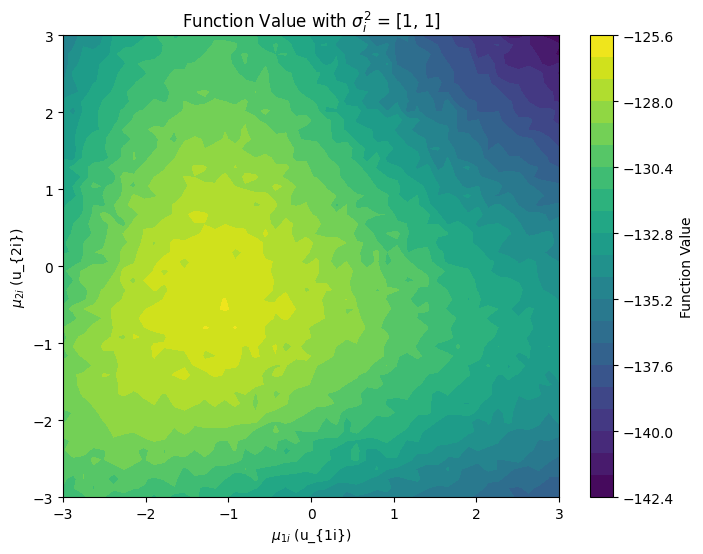

In [ ]:
# Placeholder function for ln P(A_i | h_i)
def log_p_a_given_h(h_i,i):
    """
    Dummy implementation of ln P(A_i | h_i).
    Takes h_i as a 2D vector [h_1i, h_2i] and returns a scalar.
    Replace this with the actual implemented function.

    """
    return EMFit.log_likelihood(behavioraldata[i,],np.expand_dims(h_i,axis=0))
    # For demonstration, assume a simple quadratic form
    # return -0.5 * np.sum(h_i**2)

def compute_function(u_i, sigma2_i, mu_p, sigma2_p, i, num_samples=1000):
    """
    Compute the given function for D=2 using Monte Carlo sampling.
    
    Parameters:
    - u_i: 2D array [u_1i, u_2i], mean of the Gaussian
    - sigma2_i: 2D array [sigma^2_1i, sigma^2_2i], variances (fixed)
    - mu_p: 2D array [mu_p1, mu_p2], prior mean
    - sigma2_p: 2D array [sigma^2_p1, sigma^2_p2], prior variances
    - num_samples: Number of Monte Carlo samples (default: 1000)
    
    Returns:
    - Value of the function
    """
    # Ensure inputs are numpy arrays
    u_i = np.array(u_i)  # [u_1i, u_2i]
    sigma2_i = np.array(sigma2_i)  # [sigma^2_1i, sigma^2_2i]
    mu_p = np.array(mu_p)  # [mu_p1, mu_p2]
    sigma2_p = np.array(sigma2_p)  # [sigma^2_p1, sigma^2_p2]

    # Check dimensions
    if u_i.shape != (2,) or sigma2_i.shape != (2,) or mu_p.shape != (2,) or sigma2_p.shape != (2,):
        raise ValueError("All input arrays must be 2D vectors")

    # Step 1: Monte Carlo sampling for the integral
    # Sample h_i from N(u_i, diag(sigma2_i))
    sigma_i = np.sqrt(sigma2_i)  # Standard deviations [sigma_1i, sigma_2i]
    h_samples = np.random.normal(loc=u_i, scale=sigma_i, size=(num_samples, 2))
    
    # Compute ln P(A_i | h_i) for each sample
    log_p_values = np.array([log_p_a_given_h(h,i) for h in h_samples])
    
    # Average over samples
    integral_approx = np.mean(log_p_values)

    # Step 2: Compute the second term (KL-like term)
    kl_term = 0
    for j in range(2):
        kl_term -= (sigma2_i[j] + (u_i[j] - mu_p[j])**2) / (2 * sigma2_p[j])

    # Step 3: Compute the third term (log variance term)
    log_var_term = 0.5 * np.sum(np.log(sigma2_i))

    # Combine all terms
    result = integral_approx + kl_term + log_var_term
    
    return result

def plot_function_2d(sigma2_i, mu_p, sigma2_p, index_sub, u1_range=(-2, 2), u2_range=(-2, 2), grid_size=50, num_samples=1000):
    """
    Plot the function as a 2D heatmap over u_1i and u_2i.
    
    Parameters:
    - sigma2_i: Fixed [sigma^2_1i, sigma^2_2i]
    - mu_p: Prior mean [mu_p1, mu_p2]
    - sigma2_p: Prior variances [sigma^2_p1, sigma^2_p2]
    - u1_range: Tuple (min, max) for u_1i
    - u2_range: Tuple (min, max) for u_2i
    - grid_size: Number of points in each dimension
    - num_samples: Number of Monte Carlo samples
    """
    # Create grid of u_1i and u_2i values
    u1_vals = np.linspace(u1_range[0], u1_range[1], grid_size)
    u2_vals = np.linspace(u2_range[0], u2_range[1], grid_size)
    U1, U2 = np.meshgrid(u1_vals, u2_vals)
    
    # Compute function values over the grid
    Z = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            u_i = [U1[i, j], U2[i, j]]
            Z[i, j] = compute_function(u_i, sigma2_i, mu_p, sigma2_p,index_sub, num_samples)
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.contourf(U1, U2, Z, levels=20, cmap='viridis')
    plt.colorbar(label='Function Value')
    plt.xlabel(r'$\mu_{1i}$ (u_{1i})')
    plt.ylabel(r'$\mu_{2i}$ (u_{2i})')
    plt.title(f'Function Value with $\sigma^2_i$ = {sigma2_i}')
    plt.show()
    return U1,U2,Z

# Fixed parameters
sigma2_i = [1, 1]         # Fixed variances [sigma^2_1i, sigma^2_2i]
mu_p = [0.0, 0.0]             # Prior mean [mu_p1, mu_p2]
sigma2_p = [3, 3]         # Prior variances [sigma^2_p1, sigma^2_p2]
index_sub = 50
# Plot the function
U1,U2,Z =plot_function_2d(
    sigma2_i=sigma2_i,
    mu_p=mu_p,
    sigma2_p=sigma2_p,
    index_sub=index_sub,
    u1_range=(-3, 3),
    u2_range=(-3, 3),
    grid_size=50,
    num_samples=500  # Reduced for faster plotting; increase for accuracy
)

### Parallelized Form

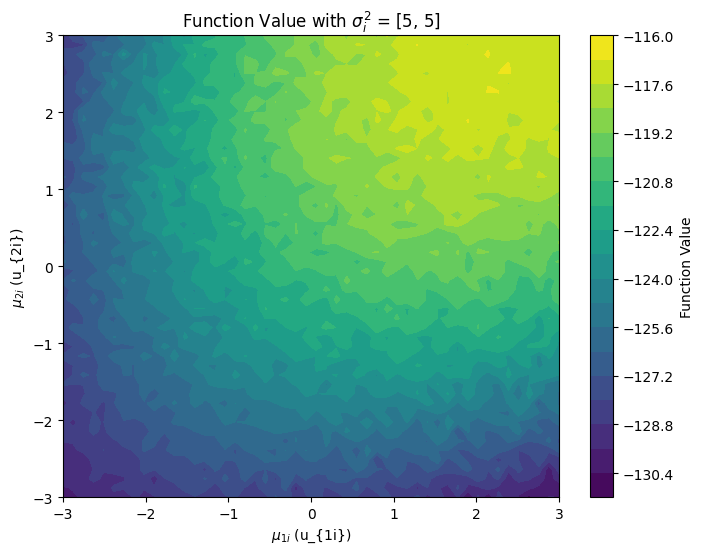

In [17]:
import numpy as np
from multiprocessing import Pool
from functools import partial
import matplotlib.pyplot as plt

# Placeholder function for ln P(A_i | h_i)
def log_p_a_given_h(h_i, i):
    """
    Dummy implementation of ln P(A_i | h_i).
    Takes h_i as a 2D vector [h_1i, h_2i] and returns a scalar.
    Replace this with the actual implemented function.
    """
    return EMFit.log_likelihood(behavioraldata[i,], np.expand_dims(h_i, axis=0))

def compute_function(u_i, sigma2_i, mu_p, sigma2_p, i, num_samples=1000):
    """
    Compute the given function for D=2 using Monte Carlo sampling.
    """
    u_i = np.array(u_i)
    sigma2_i = np.array(sigma2_i)
    mu_p = np.array(mu_p)
    sigma2_p = np.array(sigma2_p)

    if u_i.shape != (2,) or sigma2_i.shape != (2,) or mu_p.shape != (2,) or sigma2_p.shape != (2,):
        raise ValueError("All input arrays must be 2D vectors")

    sigma_i = np.sqrt(sigma2_i)
    h_samples = np.random.normal(loc=u_i, scale=sigma_i, size=(num_samples, 2))
    log_p_values = np.array([log_p_a_given_h(h, i) for h in h_samples])
    integral_approx = np.mean(log_p_values)

    kl_term = 0
    for j in range(2):
        kl_term -= (sigma2_i[j] + (u_i[j] - mu_p[j])**2) / (2 * sigma2_p[j])

    log_var_term = 0.5 * np.sum(np.log(sigma2_i))
    result = integral_approx + kl_term + log_var_term
    return result

# Wrapper function for parallel computation
def compute_function_wrapper(args):
    """
    Wrapper to unpack arguments for compute_function in parallel processing.
    
    Parameters:
    - args: Tuple of (i, j, u_i, sigma2_i, mu_p, sigma2_p, index_sub, num_samples)
    
    Returns:
    - (i, j, result): Tuple of grid indices and computed function value
    """
    i, j, u_i, sigma2_i, mu_p, sigma2_p, index_sub, num_samples = args
    result = compute_function(u_i, sigma2_i, mu_p, sigma2_p, index_sub, num_samples)
    return (i, j, result)

def plot_function_2d(sigma2_i, mu_p, sigma2_p, index_sub, u1_range=(-2, 2), u2_range=(-2, 2), grid_size=50, num_samples=1000):
    """
    Plot the function as a 2D heatmap over u_1i and u_2i with parallel computation.
    """
    # Create grid of u_1i and u_2i values
    u1_vals = np.linspace(u1_range[0], u1_range[1], grid_size)
    u2_vals = np.linspace(u2_range[0], u2_range[1], grid_size)
    U1, U2 = np.meshgrid(u1_vals, u2_vals)
    
    # Prepare arguments for parallel computation
    Z = np.zeros((grid_size, grid_size))
    tasks = [
        (i, j, [U1[i, j], U2[i, j]], sigma2_i, mu_p, sigma2_p, index_sub, num_samples)
        for i in range(grid_size)
        for j in range(grid_size)
    ]
    
    # Use multiprocessing Pool to parallelize computation
    with Pool() as pool:
        results = pool.map(compute_function_wrapper, tasks)
    
    # Assign results to Z
    for i, j, value in results:
        Z[i, j] = value
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.contourf(U1, U2, Z, levels=20, cmap='viridis')
    plt.colorbar(label='Function Value')
    plt.xlabel(r'$\mu_{1i}$ (u_{1i})')
    plt.ylabel(r'$\mu_{2i}$ (u_{2i})')
    plt.title(f'Function Value with $\sigma^2_i$ = {sigma2_i}')
    plt.show()
    return U1, U2, Z

# Fixed parameters
sigma2_i = [5,5]
mu_p = [0.0, 0.0]
sigma2_p = [3, 3]
index_sub = 34

# Plot the function
U1, U2, Z = plot_function_2d(
    sigma2_i=sigma2_i,
    mu_p=mu_p,
    sigma2_p=sigma2_p,
    index_sub=index_sub,
    u1_range=(-3, 3),
    u2_range=(-3, 3),
    grid_size=50,
    num_samples=200
)

In [12]:
samples[index_sub]

array([0.98664789, 0.75556228])

In [13]:
EMFit.environment.agent.logistic_transform(samples[index_sub])

array([4.30263852, 1.12850165])

In [20]:
EMFit.environment.agent.inv_logistic_transform(np.array([2,2.25]))

array([0.88079708, 0.90465054])

## Track the optimization path of mu

In [18]:
import torch
import torch.optim as optim
from torch.distributions import MultivariateNormal
def OptimizeMu(behavioral_data: NDArray, sigma1: float, initial_guess: NDArray,learning_rate: float,prior_mean_tensor:float,prior_variance_tensor:float,num_iters: int = 100) -> NDArray:
    """
    Optimize Q distribution over Latant variabels to obtain the posterior in E Step.
    
    Parameters:
    - behavioral_data (Tuple[NDArray, NDArray, NDArray]): A tuple of arrays containing states, actions, and rewards/observations.
    - initial_guess (NDArray): The initial parameter estimates.
    
    Returns:
    - NDArray: The optimized parameter estimates.
    """
    mu = torch.tensor(initial_guess, dtype=torch.float32, requires_grad=True)
    sigma = torch.tensor(sigma1, dtype=torch.float32, requires_grad=False)
    
    collective_path = torch.tensor(np.zeros((num_iters,mu.shape[0])),requires_grad=False)
    collective_path[0,:] = mu
    
    optimizer = torch.optim.Adam([mu], lr=learning_rate)
    
    for i in range(num_iters):
            optimizer.zero_grad()
            grad_mu,logP = stochastic_gradient(sigma, mu, behavioral_data,prior_mean_tensor=prior_mean_tensor,prior_variance_tensor=prior_variance_tensor)
            
            # sigma.grad = -grad_sigma
            mu.grad = -grad_mu
            
            optimizer.step()

            collective_path[i,:] = mu
            
            if (i+1) % 1000 == 0:
                print(f"Iteration {i+1}: sigma = {sigma.detach().numpy()}, mu = {mu.detach().numpy()}, logP = {logP.detach().numpy()}")
    
    collective_path = collective_path.detach().numpy()
    return collective_path
      

def stochastic_gradient(sigma, mu, behavioral_data,prior_mean_tensor,prior_variance_tensor):
    # sigma, mu = torch.tensor(sigma,dtype=torch.float32), torch.tensor(mu,dtype=torch.float32)  # Convert inputs to tensors
    
    # h_i = torch.tensor(torch.multivariate_normal(mu, torch.diag(sigma), size=(10,)), requires_grad=False)  # Ensure h_i is a tensor but not part of computation graph
    # Sample from multivariate normal distribution
    dist = MultivariateNormal(mu, torch.diag(sigma))
    h_i = dist.sample((1,))  # Generate 1 samples

    logP = torch.tensor(EMFit.log_likelihood(behavioral_data=behavioral_data, parameters=h_i.detach().numpy()),dtype=torch.float32)  # Convert h_i to NumPy before passing to log_likelihood
    
    # grad1_sigma = (-1 / sigma + ((h_i[0] - mu)**2 / sigma**3)) * logP
    # grad_sigma = 1 / sigma - sigma / EMFit.prior_variance_tensor + grad1_sigma
    
    grad1_mu = ((h_i[0] - mu) / (sigma**2)) * (logP+120)
    grad_mu = grad1_mu-((mu - prior_mean_tensor) / prior_variance_tensor) 
    
    # return grad_sigma, grad_mu
    return grad_mu,logP

Path_mu = OptimizeMu(behavioral_data=behavioraldata[index_sub],sigma1=np.array(sigma2_i)**0.5, initial_guess=np.array([0,0]),learning_rate=0.01,
          prior_mean_tensor=torch.tensor(mu_p,requires_grad=False),prior_variance_tensor=torch.tensor(sigma2_p,requires_grad=False),
          num_iters=10000)

Path_mu


Iteration 1000: sigma = [2.236068 2.236068], mu = [1.4485233 1.8089759], logP = -110.74784851074219
Iteration 2000: sigma = [2.236068 2.236068], mu = [1.5501969 1.7410873], logP = -118.19169616699219
Iteration 3000: sigma = [2.236068 2.236068], mu = [1.5241207 1.9008459], logP = -113.4937973022461
Iteration 4000: sigma = [2.236068 2.236068], mu = [1.546     1.9538907], logP = -129.0030059814453
Iteration 5000: sigma = [2.236068 2.236068], mu = [1.486414  1.8919563], logP = -121.16554260253906
Iteration 6000: sigma = [2.236068 2.236068], mu = [1.4655632 1.972661 ], logP = -114.13939666748047
Iteration 7000: sigma = [2.236068 2.236068], mu = [1.5176752 2.0088196], logP = -120.68946838378906
Iteration 8000: sigma = [2.236068 2.236068], mu = [1.4205478 1.9180137], logP = -112.38127136230469
Iteration 9000: sigma = [2.236068 2.236068], mu = [1.4163262 1.807098 ], logP = -118.94880676269531
Iteration 10000: sigma = [2.236068 2.236068], mu = [1.4906226 1.9697154], logP = -113.14966583251953


array([[ 9.99999512e-03, -9.99999698e-03],
       [ 2.67360266e-03, -2.70173606e-03],
       [-6.03001099e-05,  1.48807326e-03],
       ...,
       [ 1.48814714e+00,  1.96246731e+00],
       [ 1.48974037e+00,  1.96660769e+00],
       [ 1.49062264e+00,  1.96971536e+00]])

In [27]:
samples[0]

array([0.76673502, 0.76489082])

tensor([1, 1])

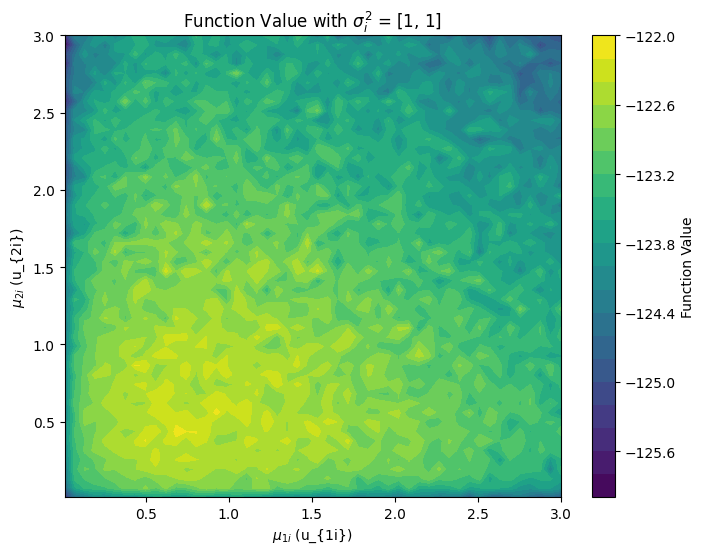

In [23]:
mu1 = np.linspace(-10,10,100)
mu2 = np.linspace(-10,10,100)

sigma1 = np.linspace(0,10,100)
sigma2 = np.linspace(0,10,100)


# Placeholder function for ln P(A_i | h_i)
def log_p_a_given_h(h_i,i):
    """
    Dummy implementation of ln P(A_i | h_i).
    Takes h_i as a 2D vector [h_1i, h_2i] and returns a scalar.
    Replace this with the actual implemented function.

    """
    return EMFit.log_likelihood(behavioraldata[i,],np.expand_dims(h_i,axis=0))
    # For demonstration, assume a simple quadratic form
    # return -0.5 * np.sum(h_i**2)

def compute_function(u_i, sigma2_i, mu_p, sigma2_p, i, num_samples=1000):
    """
    Compute the given function for D=2 using Monte Carlo sampling.
    
    Parameters:
    - u_i: 2D array [u_1i, u_2i], mean of the Gaussian
    - sigma2_i: 2D array [sigma^2_1i, sigma^2_2i], variances (fixed)
    - mu_p: 2D array [mu_p1, mu_p2], prior mean
    - sigma2_p: 2D array [sigma^2_p1, sigma^2_p2], prior variances
    - num_samples: Number of Monte Carlo samples (default: 1000)
    
    Returns:
    - Value of the function
    """
    # Ensure inputs are numpy arrays
    u_i = np.array(u_i)  # [u_1i, u_2i]
    sigma2_i = np.array(sigma2_i)  # [sigma^2_1i, sigma^2_2i]
    mu_p = np.array(mu_p)  # [mu_p1, mu_p2]
    sigma2_p = np.array(sigma2_p)  # [sigma^2_p1, sigma^2_p2]

    # Check dimensions
    if u_i.shape != (2,) or sigma2_i.shape != (2,) or mu_p.shape != (2,) or sigma2_p.shape != (2,):
        raise ValueError("All input arrays must be 2D vectors")

    # Step 1: Monte Carlo sampling for the integral
    # Sample h_i from N(u_i, diag(sigma2_i))
    sigma_i = np.sqrt(sigma2_i)  # Standard deviations [sigma_1i, sigma_2i]
    h_samples = np.random.normal(loc=u_i, scale=sigma_i, size=(num_samples, 2))
    
    # Compute ln P(A_i | h_i) for each sample
    log_p_values = np.array([log_p_a_given_h(h,i) for h in h_samples])
    
    # Average over samples
    integral_approx = np.mean(log_p_values)

    # Step 2: Compute the second term (KL-like term)
    kl_term = 0
    for j in range(2):
        kl_term -= (sigma2_i[j] + (u_i[j] - mu_p[j])**2) / (2 * sigma2_p[j])

    # Step 3: Compute the third term (log variance term)
    log_var_term = 0.5 * np.sum(np.log(sigma2_i))

    # Combine all terms
    result = integral_approx + kl_term + log_var_term
    
    return result

def plot_function_2d(sigma2_i, mu_p, sigma2_p, index_sub, u1_range=(-2, 2), u2_range=(-2, 2), grid_size=50, num_samples=1000):
    """
    Plot the function as a 2D heatmap over u_1i and u_2i.
    
    Parameters:
    - sigma2_i: Fixed [sigma^2_1i, sigma^2_2i]
    - mu_p: Prior mean [mu_p1, mu_p2]
    - sigma2_p: Prior variances [sigma^2_p1, sigma^2_p2]
    - u1_range: Tuple (min, max) for u_1i
    - u2_range: Tuple (min, max) for u_2i
    - grid_size: Number of points in each dimension
    - num_samples: Number of Monte Carlo samples
    """
    # Create grid of u_1i and u_2i values
    u1_vals = np.linspace(u1_range[0], u1_range[1], grid_size)
    u2_vals = np.linspace(u2_range[0], u2_range[1], grid_size)
    U1, U2 = np.meshgrid(u1_vals, u2_vals)
    
    # Compute function values over the grid
    Z = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            u_i = [U1[i, j], U2[i, j]]
            Z[i, j] = compute_function(sigma2_i,u_i, mu_p, sigma2_p,index_sub, num_samples)
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.contourf(U1, U2, Z, levels=20, cmap='viridis')
    plt.colorbar(label='Function Value')
    plt.xlabel(r'$\mu_{1i}$ (u_{1i})')
    plt.ylabel(r'$\mu_{2i}$ (u_{2i})')
    plt.title(f'Function Value with $\sigma^2_i$ = {sigma2_i}')
    plt.show()

# Example usage
if __name__ == "__main__":
    # Fixed parameters
    sigma2_i = [1, 1]         # Fixed variances [sigma^2_1i, sigma^2_2i]
    mu_p = [0.0, 0.0]             # Prior mean [mu_p1, mu_p2]
    sigma2_p = [1.0, 1.0]         # Prior variances [sigma^2_p1, sigma^2_p2]
    
    # Plot the function
    plot_function_2d(
        sigma2_i=sigma2_i,
        mu_p=mu_p,
        sigma2_p=sigma2_p,
        index_sub=0,
        u1_range=(0.01, 3),
        u2_range=(0.01, 3),
        grid_size=50,
        num_samples=100  # Reduced for faster plotting; increase for accuracy
    )




In [4]:
a = np.ones((1,10))

b = -a
b

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]])

## Parallelization

In [17]:
mu1 = np.linspace(-10,10,100)
mu2 = np.linspace(-10,10,100)

sigma1 = np.linspace(0,10,100)
sigma2 = np.linspace(0,10,100)


import numpy as np

# Placeholder function for ln P(A_i | h_i)
def log_p_a_given_h(h_i,i):
    """
    Dummy implementation of ln P(A_i | h_i).
    Takes h_i as a 2D vector [h_1i, h_2i] and returns a scalar.
    Replace this with the actual implemented function.

    """
    return EMFit.log_likelihood(behavioraldata[i,],np.expand_dims(h_i,axis=0))
    # For demonstration, assume a simple quadratic form
    # return -0.5 * np.sum(h_i**2)

def compute_function(u_i, sigma2_i, mu_p, sigma2_p, i, num_samples=1000):
    """
    Compute the given function for D=2 using Monte Carlo sampling.
    
    Parameters:
    - u_i: 2D array [u_1i, u_2i], mean of the Gaussian
    - sigma2_i: 2D array [sigma^2_1i, sigma^2_2i], variances (fixed)
    - mu_p: 2D array [mu_p1, mu_p2], prior mean
    - sigma2_p: 2D array [sigma^2_p1, sigma^2_p2], prior variances
    - num_samples: Number of Monte Carlo samples (default: 1000)
    
    Returns:
    - Value of the function
    """
    # Ensure inputs are numpy arrays
    u_i = np.array(u_i)  # [u_1i, u_2i]
    sigma2_i = np.array(sigma2_i)  # [sigma^2_1i, sigma^2_2i]
    mu_p = np.array(mu_p)  # [mu_p1, mu_p2]
    sigma2_p = np.array(sigma2_p)  # [sigma^2_p1, sigma^2_p2]

    # Check dimensions
    if u_i.shape != (2,) or sigma2_i.shape != (2,) or mu_p.shape != (2,) or sigma2_p.shape != (2,):
        raise ValueError("All input arrays must be 2D vectors")

    # Step 1: Monte Carlo sampling for the integral
    # Sample h_i from N(u_i, diag(sigma2_i))
    sigma_i = np.sqrt(sigma2_i)  # Standard deviations [sigma_1i, sigma_2i]
    h_samples = np.random.normal(loc=u_i, scale=sigma_i, size=(num_samples, 2))
    
    # Compute ln P(A_i | h_i) for each sample
    log_p_values = np.array([log_p_a_given_h(h,i) for h in h_samples])
    
    # Average over samples
    integral_approx = np.mean(log_p_values)

    # Step 2: Compute the second term (KL-like term)
    kl_term = 0
    for j in range(2):
        kl_term -= (sigma2_i[j] + (u_i[j] - mu_p[j])**2) / (2 * sigma2_p[j])

    # Step 3: Compute the third term (log variance term)
    log_var_term = 0.5 * np.sum(np.log(sigma2_i))

    # Combine all terms
    result = integral_approx + kl_term + log_var_term
    
    return result

def plot_function_2d(sigma2_i, mu_p, sigma2_p, index_sub, u1_range=(-2, 2), u2_range=(-2, 2), grid_size=50, num_samples=1000):
    """
    Plot the function as a 2D heatmap over u_1i and u_2i.
    
    Parameters:
    - sigma2_i: Fixed [sigma^2_1i, sigma^2_2i]
    - mu_p: Prior mean [mu_p1, mu_p2]
    - sigma2_p: Prior variances [sigma^2_p1, sigma^2_p2]
    - u1_range: Tuple (min, max) for u_1i
    - u2_range: Tuple (min, max) for u_2i
    - grid_size: Number of points in each dimension
    - num_samples: Number of Monte Carlo samples
    """
    # Create grid of u_1i and u_2i values
    u1_vals = np.linspace(u1_range[0], u1_range[1], grid_size)
    u2_vals = np.linspace(u2_range[0], u2_range[1], grid_size)
    U1, U2 = np.meshgrid(u1_vals, u2_vals)
    
    def compute_at_point(i, j):
        u_i = [U1[i, j], U2[i, j]]
        return compute_function(u_i, sigma2_i, mu_p, sigma2_p,index_sub, num_samples)

    # Parallelize computation over the grid
    Z = Parallel(n_jobs=-1)(
        delayed(compute_at_point)(i, j) for i in range(grid_size) for j in range(grid_size)
    )
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.contourf(U1, U2, Z, levels=20, cmap='viridis')
    plt.colorbar(label='Function Value')
    plt.xlabel(r'$\mu_{1i}$ (u_{1i})')
    plt.ylabel(r'$\mu_{2i}$ (u_{2i})')
    plt.title(f'Function Value with $\sigma^2_i$ = {sigma2_i}')
    plt.show()

# Example usage
if __name__ == "__main__":
    # Fixed parameters
    sigma2_i = [0.5, 0.8]         # Fixed variances [sigma^2_1i, sigma^2_2i]
    mu_p = [0.0, 0.0]             # Prior mean [mu_p1, mu_p2]
    sigma2_p = [1.0, 1.0]         # Prior variances [sigma^2_p1, sigma^2_p2]
    
    # Plot the function
    plot_function_2d(
        sigma2_i=sigma2_i,
        mu_p=mu_p,
        sigma2_p=sigma2_p,
        index_sub=0,
        u1_range=(-3, 5),
        u2_range=(-3, 5),
        grid_size=50,
        num_samples=500  # Reduced for faster plotting; increase for accuracy
    )




BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

## Test Torch Optimization

In [27]:
import torch
import torch.optim as optim
from torch.distributions import MultivariateNormal


def ManualOptimizeTorch(learning_rate: float) -> NDArray:
            """
            Optimize Q distribution over Latant variabels to obtain the posterior in E Step.
            
            Parameters:
            - behavioral_data (Tuple[NDArray, NDArray, NDArray]): A tuple of arrays containing states, actions, and rewards/observations.
            - initial_guess (NDArray): The initial parameter estimates.
            
            Returns:
            - NDArray: The optimized parameter estimates.
            """
            mu = torch.tensor([10,10], dtype=torch.float32, requires_grad=True)

          
            
            optimizer = torch.optim.Adam([mu], lr=learning_rate)
            num_iters = 100
            for i in range(num_iters):
                  optimizer.zero_grad()
                  grad_mu = -2*(mu-2) 
                
                  mu.grad = -grad_mu
                  
                  optimizer.step()
                  
                  if (i+1) % 50 == 0:
                        print(f"Iteration {i+1}: smu = {mu.detach().numpy()}")
            
            QParameters = np.array([mu.detach().numpy()])
            return QParameters

ManualOptimizeTorch(0.1)

Iteration 50: smu = [5.4848633 5.4848633]
Iteration 100: smu = [2.9449952 2.9449952]


array([[2.9449952, 2.9449952]], dtype=float32)